In [ ]:
!pip install arrow

     |████████████████████████████████| 61kB 3.8MB/s 


In [ ]:
#import forecastio
import arrow #A much mooooooore friendlier version than datetime package. I found my new datetime love!
import json
import datetime as dt
from progressbar import ProgressBar
import forecastio
import numpy as np

"""
Forecastio is a great website for grabbing weather data. For the free version, they're only allowing 1000 API calls per day.
But for every call, you'll grab 1 day of comprehensive data from all the aggregated sources that they're using - which is a lot.
Check out their website!
https://developer.forecast.io/
"""




api_key = 'd2af52fa407f31e459ca628c71c9edaeaa'
lati = '37.817773'
long = '-122.272232'

start = dt.datetime(2006,1,1)
end = dt.datetime(2008,1,1)

f_name="{0}--{1}-at-SanFran".format(end.date(),start.date(),lati=lati,long=long)

"""
pbar=ProgressBar()
with open(f_name+'.json', 'a+') as file:
    for c_date in pbar(arrow.Arrow.range('day', start, end)):
        fore = forecastio.load_forecast(api_key, lati, long,time=c_date)
        data=fore.json
        json.dump(data, file)
        file.write('\n')
        print c_date
"""



ImportError: ignored

In [ ]:
##### import pandas as pd
import pandas as pd


'''
print pd.DatetimeIndex(pd.to_datetime(csv['sunriseTime'],unit='s',utc=True),tz=timezone('UTC')) #--timezone output are all in UTC, need to convert later
#Probably would need to do something like the following
import datetime as dt
import pytz
time_now =  dt.datetime.utcnow()  #if inputting POSIX unix epoch time, use utcfromtimestamp() function
pacific_time=pytz.timezone('America/Los_Angeles')
with_utc = time_now.replace(tzinfo=pytz.utc)
with_pacific = with_utc.astimezone(pacific_time)
'''
daily_df=pd.DataFrame()
with open('weather_2014-01-01---2016-01-01.json','rb') as f:
    lines=f.readlines()
    for line in lines:
        try:
            json = pd.read_json(line)['daily']['data'][0]
            #You can get the column names by json.keys()
            df=pd.DataFrame(json,index=(pd.to_datetime(json['sunriseTime'],unit='s'),),
                            columns=[u'summary', u'sunriseTime', u'apparentTemperatureMinTime', u'moonPhase', u'icon', u'precipType',
                                   u'apparentTemperatureMax', u'temperatureMax', u'time', u'apparentTemperatureMaxTime', u'sunsetTime',
                                   u'pressure', u'windSpeed', u'temperatureMin', u'apparentTemperatureMin', u'windBearing', u'temperatureMaxTime',
                                   u'temperatureMinTime'])
            daily_df=daily_df.append(df)
        except KeyError:
            pass
            #Finished Appending

daily_df['averageTemperature']=(daily_df['temperatureMax']+daily_df['temperatureMin'])/2  #Creating average Temperature dynamically


In [ ]:
#Now finally for some real fun
df_2015=daily_df['2015']['averageTemperature'].copy()
df_2014=daily_df['2014']['averageTemperature'].copy()

"""
#Notice I'm doing something extremely interesting here.
The problem is that I'm trying to compare year 2014 and year 2015 with the same day on the same graph, but datetime don't have
this logic of removing the year from the date. So I created a new index starting year 2015-01-01 till the end and put them on the same index
Next, I tried to hide the year from the graph. A very Hacky way to do this, but works fine.
"""


new_index=pd.date_range('2015-01-01', periods=365, freq='D')
new_df=pd.DataFrame({'Year 2014':df_2014.values, 'Year 2015':df_2015.values},index=new_index)


#Create a new column of Strings categorizing each row by months
def month_cat(num):
    num=int(num)
    if num==1: return 'Jan'
    if num==2: return 'Feb'
    if num==3: return 'Mar'
    if num==4: return 'Apr'
    if num==5: return 'May'
    if num==6: return 'Jun'
    if num==7: return 'Jul'
    if num==8: return 'Aug'
    if num==9: return 'Sep'
    if num==10: return 'Oct'
    if num==11: return 'Nov'
    if num==12: return 'Dec'

#new_df.drop('month_category', axis=1, inplace=True)
cat_list=list()
for i in new_df.index.month:
    cat_list.append(month_cat(i))
new_df['month_category']=cat_list



import datetime
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>") #Makes the graphs fitting window size of the browser.




In [ ]:
print "Time to look at the basic statistics of our data"
print new_df[['Year 2014', 'Year 2015']].describe()

print "-"*100
print "I was expecting both to have count as 365. Looks like might have some NAN values. The next thing I'm going to try to do is fill each NAN with the average temperature it is grouped in per month"

nan_index= pd.isnull(new_df[['Year 2015']]).any(1).nonzero()[0]
#print nan_index #[ 50  51 156 239 240 308 310 337 338]
print new_df.iloc[nan_index]

print "-"*100
print "I might find a more pythonic way to do this in the future, but right now I'm jus going to calculate every month's average and fill the NAN row in the associated month."
print "-"*100
print "Before conversion"
print new_df['Year 2015'].iloc[nan_index]

month_avg_2015={}
for month in new_df.groupby('month_category').groups.keys():
    month_avg_2015[month]=new_df.groupby('month_category')['Year 2015'].get_group(month).mean()


for nans in nan_index:
    new_df['Year 2015'].iloc[nans]=month_avg_2015[new_df['month_category'].iloc[nans]]

print "-"*100
print "After conversion"
print new_df['Year 2015'].iloc[nan_index]


Time to look at the basic statistics of our data
        Year 2014  Year 2015
count     365.000        356
unique    337.000        335
top        59.705         56
freq        3.000          2
----------------------------------------------------------------------------------------------------
I was expecting both to have count as 365. Looks like might have some NAN values. The next thing I'm going to try to do is fill each NAN with the average temperature it is grouped in per month
           Year 2014 Year 2015 month_category
2015-02-20     56.56       NaN            Feb
2015-02-21     57.13       NaN            Feb
2015-06-06    57.755       NaN            Jun
2015-08-28    64.115       NaN            Aug
2015-08-29    62.925       NaN            Aug
2015-11-05    64.965       NaN            Nov
2015-11-07     61.01       NaN            Nov
2015-12-04     60.72       NaN            Dec
2015-12-05    60.555       NaN            Dec
----------------------------------------------------

----------------------------------------------------------------------------------------------------
Data looks a lot better now. Finally going into some plotting. 
        Year 2014  Year 2015 month_category
count     365.000        365            365
unique    337.000        340             12
top        59.705         56            Jul
freq        3.000          2             31
----------------------------------------------------------------------------------------------------
Can't tell much from the line plot


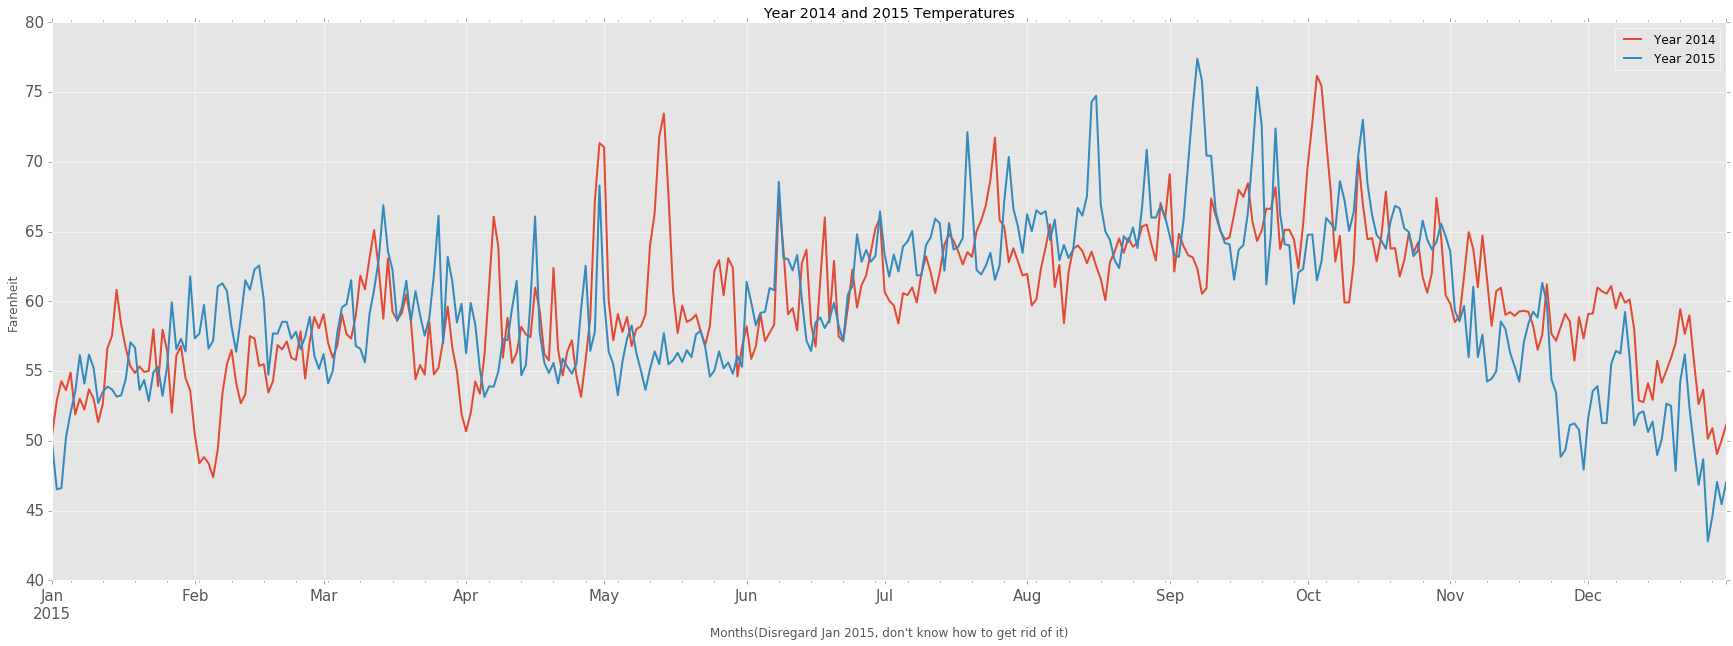

In [ ]:
print "-" * 100
print "Data looks a lot better now. Finally going into some plotting. "
print new_df.describe()


line_plot = new_df.plot(kind='line',figsize =(30,10),title="Year 2014 and 2015 Temperatures",lw=2,fontsize=15)
line_plot.set_xlabel("Months(Disregard Jan 2015, don't know how to get rid of it)")
line_plot.set_ylabel("Farenheit")

print "-" * 100
print "Can't tell much from the line plot"

----------------------------------------------------------------------------------------------------
Density plot shows in Year 2014, the temperature seemed a bit more mild and stable in comparison to Year 2015 which had a wider spread.


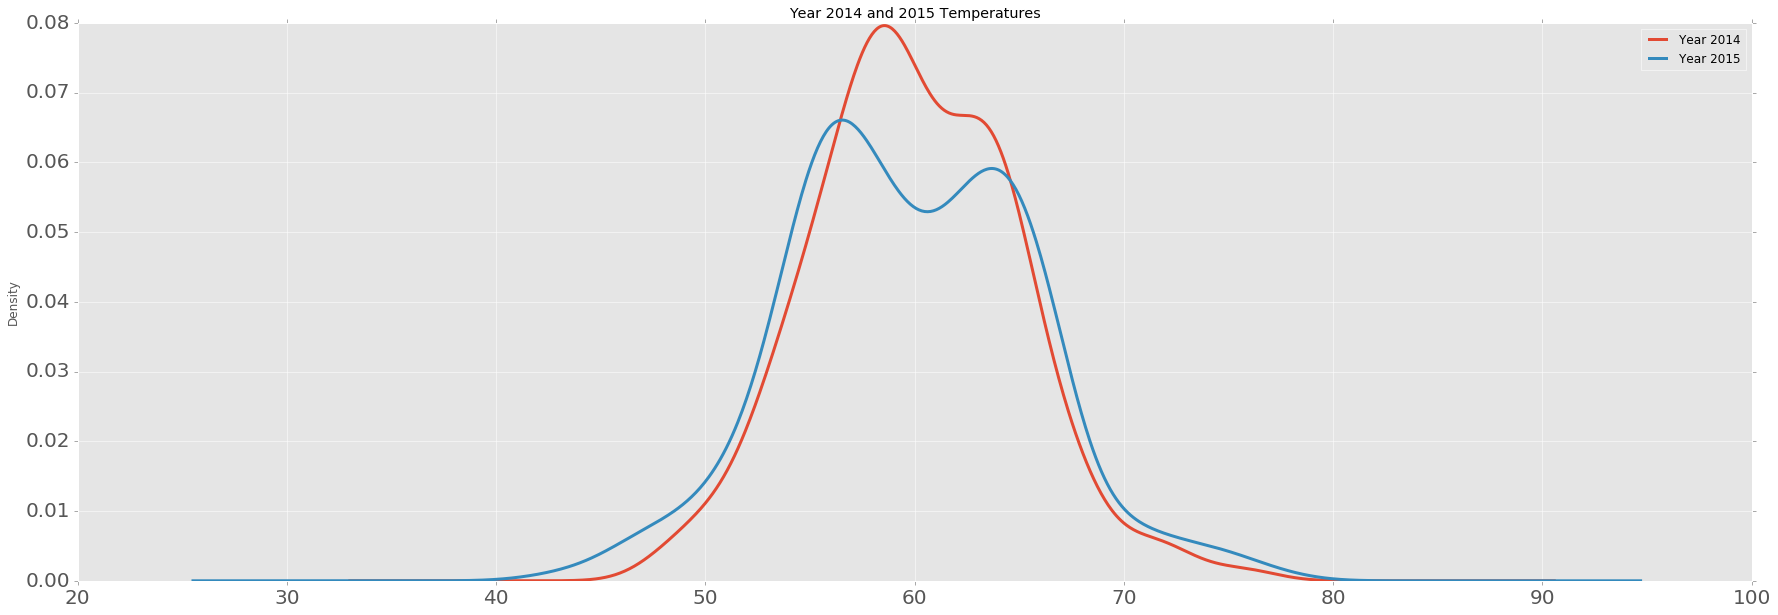

In [ ]:
line_plot = new_df.plot(kind='density',figsize =(30,10),title="Year 2014 and 2015 Temperatures", lw=3.0, fontsize=20)

print "-" * 100
print "Density plot shows in Year 2014, the temperature seemed a bit more mild and stable in comparison to Year 2015 which had a wider spread."


The Box plot also confirms this. 


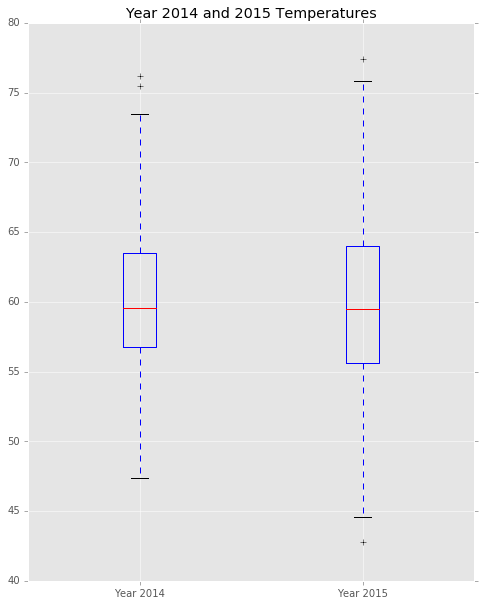

In [ ]:
new_df.plot(kind='box',figsize =(8,10),title="Year 2014 and 2015 Temperatures")

print "The Box plot also confirms this. "

In [ ]:
grouped = new_df.groupby('month_category')


#axis=0 along the row
#axis=1 along the column
#http://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns quite useful save for later

IndentationError: expected an indented block (<ipython-input-1-bd7482e4b0fb>, line 6)

Axes(0.125,0.125;0.775x0.775)
Scatter plot looks like there is a moderate positive relationship between the two years. There's a lot of clusters in the middle whereas higher temperatures had more extreme outliers. 


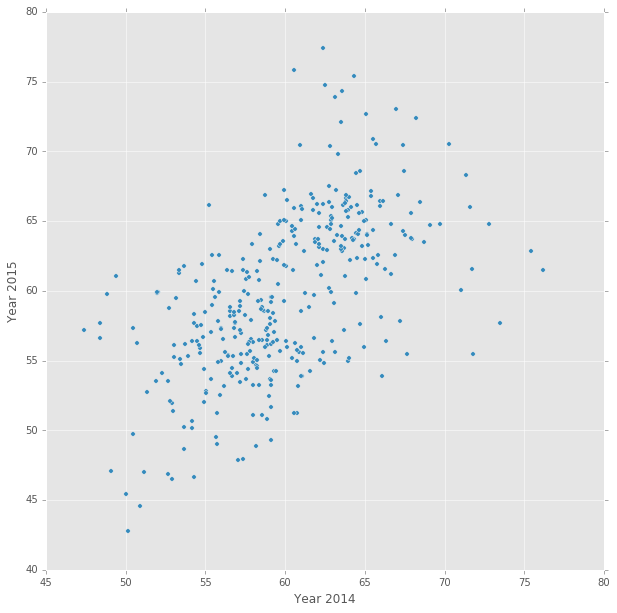

In [ ]:
print new_df.plot(kind='scatter', x='Year 2014', y='Year 2015', figsize=(10,10)) #Scatter plot



print "Scatter plot looks like there is a moderate positive relationship between the two years. There's a lot of clusters in the middle whereas higher temperatures had more extreme outliers. "



In [ ]:
from scipy import stats

t_stat, two_tail_p_value=stats.ttest_ind(new_df['Year 2014'],new_df['Year 2015'],equal_var=False)  #Conducts Welch's Test. Note that Pvalue response from stats.ttest_ind default is two tail.
print "T-Statistic is: {0} and P-Value is: {1}".format(t_stat,two_tail_p_value)
print "-"*100
print "With my alpha of 0.05, and I received a P-Value of 0.577, I have failed to prove that there is a significant difference of mean between Year 2014 Temperature and Year 2015. "
print "Though from the graphs, we can say that Year 2014 seemed to have smaller spread of temperature - a much more stable year than 2015."

T-Statistic is: 0.557834629664 and P-Value is: 0.577133796932
----------------------------------------------------------------------------------------------------
With my alpha of 0.05, and I received a P-Value of 0.577, I have failed to prove that there is a significant difference of mean between Year 2014 Temperature and Year 2015. 
Though from the graphs, we can say that Year 2014 seemed to have smaller spread of temperature - a much more stable year than 2015.
